In [82]:
from dolfinx import fem, mesh, cpp
import dolfinx.fem.petsc as petsc
import numpy as np
from mpi4py import MPI
import ufl
import matplotlib.pyplot as plt

In [83]:
lam = 1
theta = 1
T = 1.0  # Final time

In [84]:
def v_exact(t):
    return lambda x: np.cos(2 * np.pi * x[0]) * np.cos(2 * np.pi * x[1]) * np.sin(t)

def initial_s(x):
    return -np.cos(2*np.pi * x[0]) * np.cos(2*np.pi * x[1])

def initial_v(x):
    return 0*x[0]

def forward_euler_step(init, dt):
    v = init[0] - dt * init[1]
    s = init[1] + dt * init[0]
    return v, s

In [85]:
def error(h, dt):
    gamma = dt * lam / (1+lam)
    N = int(np.ceil(1/h))

    domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
    V = fem.functionspace(domain, ("Lagrange", 1))
    t = fem.Constant(domain, 0.0)
    X = ufl.SpatialCoordinate(domain)
    I_stim = 8 * ufl.pi**2 * lam/(1+lam) * ufl.sin(t) * ufl.cos(2*ufl.pi*X[0]) * ufl.cos(2*ufl.pi*X[1])

    vn = fem.Function(V)
    vn.name = "vn"
    vn.interpolate(initial_v)

    sn = fem.Function(V)
    sn.name = "sn"
    sn.interpolate(initial_s)


    vntheta = fem.Function(V)
    vntheta.name = "vntheta"

    sntheta = fem.Function(V)
    sntheta.name = "sntheta"

    v = ufl.TrialFunction(V)
    phi = ufl.TestFunction(V)
    dx = ufl.dx(domain=domain)
    a = phi * v * dx + gamma * theta * ufl.dot(ufl.grad(phi), ufl.grad(v)) * dx
    L = phi * (vntheta + dt * I_stim) * dx - gamma * (1-theta) * ufl.dot(ufl.grad(phi), ufl.grad(vntheta)) * dx
    compiled_a = fem.form(a)
    A = petsc.assemble_matrix(compiled_a)
    A.assemble()

    compiled_L = fem.form(L)
    b = fem.Function(V)

    from petsc4py import PETSc
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)

    while t.value < T:
        # Step 1
        t.value += theta * dt
        
        vntheta.x.array[:], sntheta.x.array[:] = forward_euler_step([vn.x.array, sn.x.array], theta * dt)

        # Step 2
        b.x.array[:] = 0
        petsc.assemble_vector(b.vector, compiled_L)
        
        solver.solve(b.vector, vn.vector)
        vn.x.scatter_forward()

        # Step 3
        t.value += (1-theta) * dt

        vn.x.array[:], sn.x.array[:] = forward_euler_step([vn.x.array.copy(), sntheta.x.array], (1-theta) * dt)
    
    v_ex = fem.Function(V)
    v_ex.name = "v_ex"
    v_ex.interpolate(v_exact(T))

    comm = vn.function_space.mesh.comm
    error = fem.form((vn - v_ex)**2 * ufl.dx)
    E = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    return E

In [86]:
def create_error_matrix(numspatial, numtemporal):
    hs = [1/(2**i) for i in range(4+numspatial, 4, -1)]
    dts = [1/(2**i) for i in range(5+numtemporal, 5, -1)]

    errors = np.zeros((numtemporal, numspatial))

    for itime in range(numtemporal):
        for ispace in range(numspatial):
            errors[itime, ispace] = error(hs[ispace], dts[itime])
    return errors, hs, dts

In [87]:
errors, hs, dts = create_error_matrix(4, 4)

In [88]:
def plot_error(errors, hs, dts):
    for itime in range(len(dts)):
        order = np.polyfit(np.log(hs),np.log(errors[itime]), 1)[0]
        plt.loglog(hs, errors[itime], '-o', label = 'dt = {:.3f}  '.format(dts[itime])+ 'p = {:.2f}'.format(order))
    plt.xlabel(r'$h$')
    plt.ylabel('Error')
    plt.title(r'$L_2$ error as a function of $h$ for different d$t$.' + '\n Order of convergence ' + r'$p$')
    plt.legend()
    plt.show()

## Plots after changes

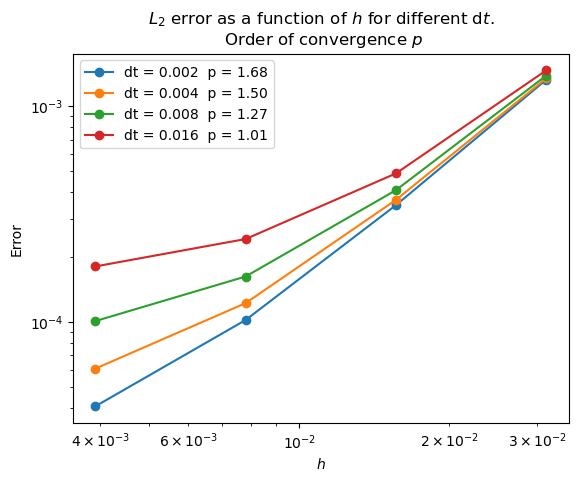

In [89]:
plot_error(errors, hs, dts)